<class 'list'>
<class 'list'>
                0             1             2             3       \
time      1.578694e+12  1.578695e+12  1.578695e+12  1.578695e+12   
SNX/USDT  3.398000e+00  3.131000e+00  3.177000e+00  3.161000e+00   
ETH/USDT  1.420100e+02  1.424300e+02  1.423800e+02  1.424600e+02   

                4             5             6             7       \
time      1.578695e+12  1.578695e+12  1.578696e+12  1.578696e+12   
SNX/USDT  3.169000e+00  3.153000e+00  3.110000e+00  3.088000e+00   
ETH/USDT  1.424900e+02  1.426500e+02  1.427100e+02  1.428400e+02   

                8             9       ...        175068        175069  \
time      1.578696e+12  1.578696e+12  ...  1.610282e+12  1.610282e+12   
SNX/USDT  3.116000e+00  3.072000e+00  ...           NaN           NaN   
ETH/USDT  1.428900e+02  1.429000e+02  ...  1.295570e+03  1.295760e+03   

                175070        175071        175072        175073  \
time      1.610282e+12  1.610282e+12  1.610283e+12  1.610283e+1

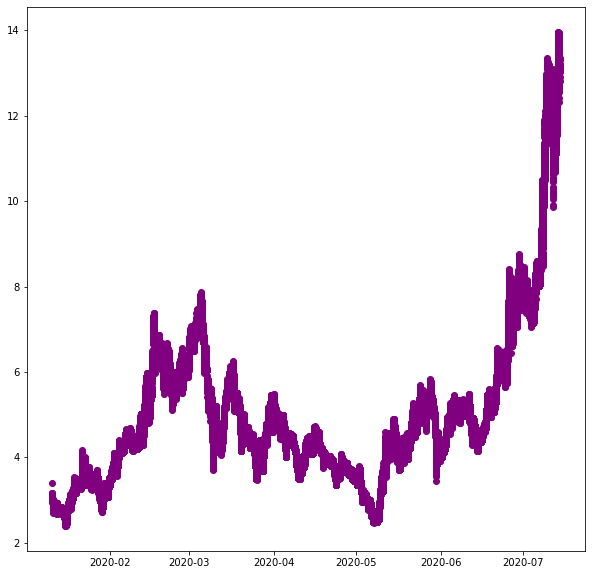

In [3]:
from dataToDictionnary import *
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
#import backtester.dataloader as dl
import backtester
import time
# Load the prices data for a stock

exchanges = ['binance']
pairs = ['SNX/USDT','ETH/USDT']
durations = ['1d']
#pairs = ['ETH/USDT']
data = dataToDico(pairs, durations, exchanges)
#print(data)
df=pd.DataFrame.from_dict(data, orient='index')
print(df.head())
print(df.nunique())
df = df.transpose()
df=df.dropna()
df['time'] = pd.to_datetime(df['time'],unit='ms')
print(df.head())
print(len(df))

#prices = df['ENJ/USDT']
#print(type(df['ENJ/USDT'][1]))
start = '0'
end = '150'
m= 'PG'
# Compute the cumulative moving average of the price

#df['mu'] = df['LRC/USDT'][:i].mean() for i in range(len(prices))
#df['mu']=ma
print(df.info())
# Plot the price and the moving average
plt.figure(figsize=(15,7))
plt.plot(df['time'],df[pairs[0]])
print(df.time)
#plt.plot(df['mu']);
plt.close()
plt.show()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(df['time'],
        df[pairs[0]],
        color='purple')
plt.show()


In [ ]:
from statsmodels.regression.rolling import RollingOLS
"""Creates a hedge ratio between the two symbols by calculating
    a rolling linear regression with a defined lookback period. This
    is then used to create a z-score of the 'spread' between the two
    symbols based on a linear combination of the two."""
def calculate_spread_zscore(df,lookback=100):
    # Use the pandas Ordinary Least Squares method to fit a rolling
    # linear regression between the two closing price time series
    print("Fitting the rolling Linear Regression...")
    y=df[pairs[0]]
    x=df[pairs[1]]

    #print(df.head())
    #print(y)
    model = RollingOLS(x,y, lookback).fit()
    #print(df.head())
    # Construct the hedge ratio and eliminate the first 
    # lookback-length empty/NaN period
    df['hedge_ratio'] = model.params
    #print(model.params)
    #print(df['hedge_ratio'][150])
    df = df.dropna()
    #print(df.head())

    # Create the spread and then a z-score of the spread
    print("Creating the spread/zscore columns...")
    df['spread'] = df[pairs[0]] - df['hedge_ratio']*df[pairs[1]]
    df['zscore'] = (df['spread'] - np.mean(df['spread']))/np.std(df['spread'])
    return df


In [110]:
portfolio.iloc[-1]['returns']

1.0

In [186]:
# mr_spy_iwm.py

def create_long_short_market_signals(df, 
                                     z_entry_threshold=2.0, 
                                     z_exit_threshold=1.0):
    
    z_entry_threshold=2.0
    z_exit_threshold=1.0
    

    # Calculate when to be long, short and when to exit
    df['longs'] = (df['zscore'] <= -z_entry_threshold)*1.0
    df['shorts'] = (df['zscore'] >= z_entry_threshold)*1.0

    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore    df['exits'] = (np.abs(df['zscore']) <= z_exit_threshold)*1.0

    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    df['long_market'] = 0.0
    df['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    print("Calculating when to be in the market (long and short)...")
    for i, b in (df.iterrows()):
        #print(b)
        # Calculate longs
        if b['longs'] == 1.0:
            #print('ok')
            long_market = 1            
        # Calculate shorts
        if b['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        #df.loc[i]['long_market'] = long_market
        df.at[i, 'long_market'] = long_market
        df.at[i, 'short_market'] = short_market
        #df.loc[i]['short_market'] = short_market
        
        #print(df.loc[i])
        #print(b[1])
    #print(df.head())
    return df

In [187]:
# mr_spy_iwm.py

def create_portfolio_returns(df):
    """Creates a portfolio pandas DataFrame which keeps track of
    the account equity and ultimately generates an equity curve.
    This can be used to generate drawdown and risk/reward ratios."""
    
    
    print("Constructing a portfolio...")
    portfolio = pd.DataFrame(index=df.index)
    portfolio['positions'] = df['long_market'] - df['short_market']
    portfolio[pairs[0]] = -1.0 * df[pairs[0]] * portfolio['positions']
    portfolio[pairs[1]] = df[pairs[1]] * portfolio['positions']
    portfolio['total'] = portfolio[pairs[0]] + portfolio[pairs[1]]

    # Construct a percentage returns stream and eliminate all 
    # of the NaN and -inf/+inf cells
    print("Constructing the equity curve...")
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)

    # Calculate the full equity curve
    portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()

    return portfolio

Calculating lookback=50...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=60...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=70...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=80...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns...
Calculating when to be in the market (long and short)...
Constructing a portfolio...
Constructing the equity curve...
Calculating lookback=90...
Fitting the rolling Linear Regression...
Creating the spread/zscore columns..

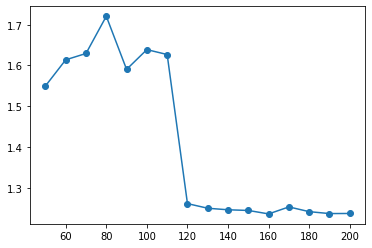

Plotting the performance charts...


<ipython-input-198-fb2a3235e58c>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


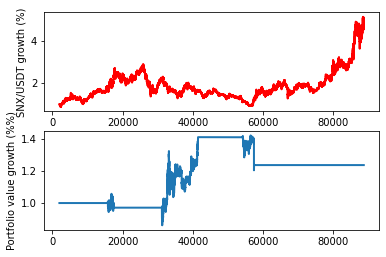

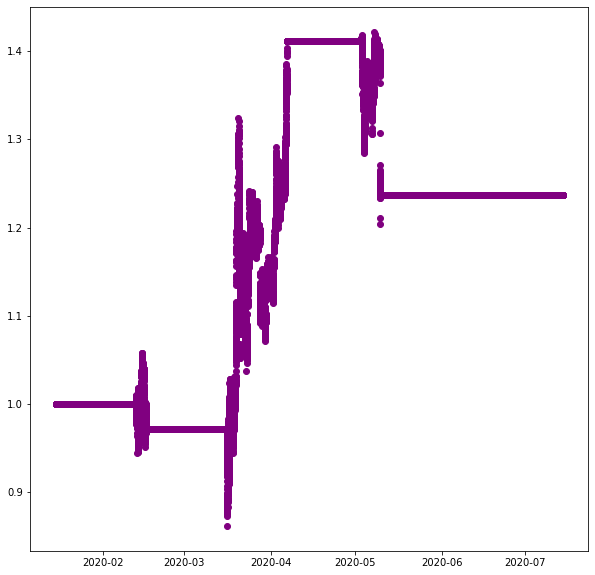

In [198]:
lookbacks = range(50, 210, 10)
returns = []

# Adjust lookback period from 50 to 200 in increments
# of 10 in order to produce sensitivities
for lb in lookbacks: 
    print("Calculating lookback=%s..." % lb)
    #pairs = create_pairs_dataframe(datadir, symbols)
    
    df = calculate_spread_zscore(df, lookback=lb)
    
    df = create_long_short_market_signals(df, 
                                            z_entry_threshold=2.0, 
                                            z_exit_threshold=1.0)
    #print(df.loc[df['long_market']==1].count())
    portfolio = create_portfolio_returns(df)
    returns.append(portfolio.iloc[-1]['returns'])

print("Plot the lookback-performance scatterchart...")
plt.plot(lookbacks, returns, '-o')
plt.show()

print("Plotting the performance charts...")
fig = plt.figure()
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(211,  ylabel='%s growth (%%)' % pairs[0])
(df[pairs[0]].pct_change()+1.0).cumprod().plot(ax=ax1, color='r', lw=2.)
ax2 = fig.add_subplot(212, ylabel='Portfolio value growth (%%)')
portfolio['returns'].plot(ax=ax2, lw=2.)
fig.show()
fig, ax = plt.subplots(figsize=(10, 10))
# Add x-axis and y-axis
ax.scatter(df['time'],
        portfolio['returns'],
        color='purple')
plt.show()

In [196]:


# Compute the z-scores for each day using the historical data up to that day
zscores = []
for i in range(0, len(df['LRC/USDT'])):
    zscores.append((df['LRC/USDT'][i] - df['mu'][i]) / np.std(df['LRC/USDT'][:i]))
df['zscores'] = zscores                                                 
# Start with no money and no positions
money = 1
count = 0
for i in range(len(prices)):
    # Sell short if the z-score is > 1
    if zscores[i] > 1:
        money += df['LRC/USDT'][i]
        count -= 1
    # Buy long if the z-score is < 1
    elif zscores[i] < -1:
        money -= df['LRC/USDT'][i]
        count += 1
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscores[i]) < 0.5:
        money += count*df['LRC/USDT'][i]
        count = 0
print(money)
print(count)


KeyError: 'LRC/USDT'

In [197]:
# Fetch prices data for 10 stocks from different sectors and plot returns

for pair in pairs:
    returns[pair] = df[pair]/df[pair].shift(-1) -1
#returns = prices/prices.shift(-1) -1
returns.plot(figsize=(15,7), color=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                     'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Returns')

# Convert to numpy array to make manipulation easier
data = np.array(prices);

TypeError: list indices must be integers or slices, not str